# Examine Results

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom_test, chi2_contingency
import seaborn as sns

from convnwb.paths import Paths
from convnwb.io import get_files, load_json, load_jsons_to_df, load_matfile

from spiketools.plts.data import plot_hist, plot_bar
from spiketools.plts.utils import make_axes, save_figure
from spiketools.plts.annotate import add_hlines

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
# Set pandas display options
pd.options.display.max_columns = None

## Settings

In [95]:
# Set which experiment version to run
experiment = 'THO'

In [96]:
# Define list of analyses
analyses = ['allchest', 'fullchest', 'emptychest',
            #'place',
            'target', 'serial']

# Collect names of analysis columns
analysis_columns = ['is_' + analysis for analysis in analyses]

In [97]:
# Set the folder to load results from
data_path = '../results/units/' + experiment

## Check Files

In [98]:
# Get the list of files
res_files = get_files(data_path, select='session')

In [99]:
# # Drop a specific set of files
# res_files = [file for file in res_files if 'wv003' not in file]

In [100]:
# # Select a specific set of files
# res_files = [file for file in res_files if 'wv001' in file]

In [101]:
# Check the number of available files
n_files = len(res_files)
n_files

609

## Load Example File

In [102]:
# Load an example file
file = res_files[0]
data = load_json(file, folder=str(data_path))

In [103]:
# # Check example file
# data

## Collect Results

In [104]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=data_path)

In [105]:
# # Clean up some datatypes - cast integers
# set_ints = ['uid', 'wvID', 'keep', 'cluster', 'n_spikes']
# all_results[set_ints] = all_results[set_ints].astype('int')

In [106]:
# Check the columns
all_results.columns

Index(['uid', 'session_id', 'subject_id', 'wvID', 'keep', 'n_spikes',
       'firing_rate', 'cluster', 'channel', 'location', 'fr_t_val_all',
       'fr_p_val_all', 'fr_t_val_empt', 'fr_p_val_empt', 'fr_t_val_full',
       'fr_p_val_full', 'target_anova', 'serial_anova',
       'target_anova_surr_p_val', 'target_anova_surr_z_score',
       'serial_anova_surr_p_val', 'serial_anova_surr_z_score'],
      dtype='object')

In [107]:
# Check the head of the results
all_results.head()

,uid,session_id,subject_id,wvID,keep,n_spikes,firing_rate,cluster,channel,location,fr_t_val_all,fr_p_val_all,fr_t_val_empt,fr_p_val_empt,fr_t_val_full,fr_p_val_full,target_anova,serial_anova,target_anova_surr_p_val,target_anova_surr_z_score,serial_anova_surr_p_val,serial_anova_surr_z_score
0,0,THO_wv001_session_0,wv001,1,True,595,0.403130,5169,A10,LAH,0.096174,0.923585,-0.627103,0.534661,0.607628,0.545766,0.511021,0.676014,0.904,-0.999782,0.570,-0.410471
1,2,THO_wv001_session_0,wv001,3,True,22559,15.211009,5200,A10,LAH,0.532078,0.595914,1.401202,0.169959,-0.540276,0.591040,2.266768,1.098669,0.030,2.194301,0.306,0.140257
2,3,THO_wv001_session_0,wv001,4,True,4583,3.092074,5203,A10,LAH,1.323994,0.188682,0.117595,0.907061,1.616886,0.111238,1.687129,2.034143,0.139,1.095229,0.107,1.192757
3,4,THO_wv001_session_0,wv001,5,True,990,0.673605,2248,A12,LAH,0.000000,1.000000,-0.597614,0.553945,0.433472,0.666253,0.788821,0.686159,0.609,-0.402132,0.611,-0.491061
4,5,THO_wv001_session_0,wv001,6,True,5965,4.031982,2303,A12,LAH,-1.315754,0.191423,0.828417,0.413048,-2.313347,0.024208,1.297559,0.678876,0.164,0.877834,0.380,-0.033443


### Unit Checks

In [108]:
# Firing rate threshold checks
print('# neurons fr < 0.15: \t', sum(all_results.firing_rate < 0.15))
print('# neurons fr < 0.50: \t', sum(all_results.firing_rate < 0.50))

# neurons fr < 0.15: 	 49
# neurons fr < 0.50: 	 211


In [109]:
# # Plot the distribution of firing rates
# plot_hist(all_results['firing_rate'].values)

In [110]:
# Add a marker for firing rate threshold in the TH experiment
all_results['keep_th'] = (all_results['firing_rate'] < 0.15).values

In [111]:
# #
# all_results = all_results[all_results.firing_rate > 0.15]

In [112]:
# Check number of neurons
n_units = len(all_results)
print('# neurons: ', n_units)

# neurons:  609


### Location Checks

In [113]:
# Check the set of sampled locations
locations = set(all_results['location'])
locations

{'LA', 'LAH', 'LPH', 'RA', 'RAH', 'RPH'}

In [114]:
# Check location counts
all_results['location'].value_counts()

LA     250
LPH    120
RA      88
LAH     84
RAH     37
RPH     30
Name: location, dtype: int64

<AxesSubplot:>

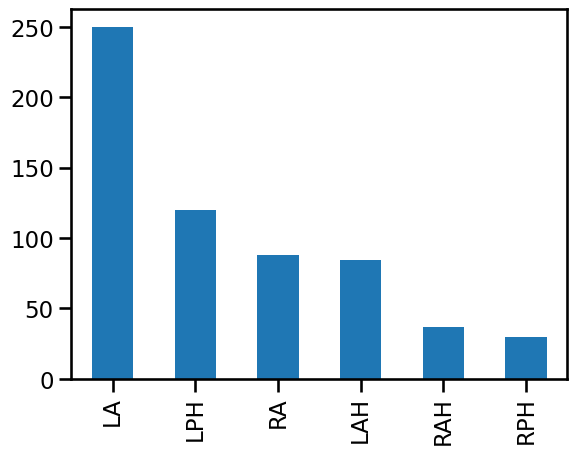

In [115]:
# Plot the counts per location
all_results['location'].value_counts().plot(kind='bar')

In [116]:
# Define location map
locmap = {'LA' : 'AMY',
          'RA' : 'AMY',
          'LAH' : 'AH',
          'RAH' : 'AH',
          'LPH' : 'PH',
          'RPH' : 'PH'}

In [117]:
# Set and collect which area each unit it is
all_results['region'] = all_results['location'].map(locmap)

In [118]:
# Check area counts
all_results['region'].value_counts()

AMY    338
PH     150
AH     121
Name: region, dtype: int64

<AxesSubplot:>

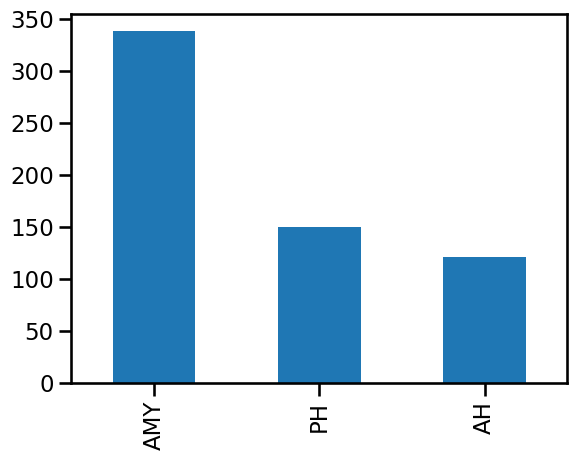

In [119]:
# Plot the counts per area
all_results['region'].value_counts().plot(kind='bar')

In [120]:
# Check the set of sampled areas
regions = set(all_results['region'])
regions

{'AH', 'AMY', 'PH'}

### Binary labels

In [121]:
# Set significance level
ALPHA_LEVEL = 0.05

In [122]:
# Add binary labels for statistical tests
all_results['is_allchest'] = all_results['fr_p_val_all'] < ALPHA_LEVEL
all_results['is_fullchest'] = all_results['fr_p_val_full'] < ALPHA_LEVEL
all_results['is_emptychest'] = all_results['fr_p_val_empt'] < ALPHA_LEVEL
#all_results['is_place'] = all_results['place_anova_surr_p_val'] < ALPHA_LEVEL
all_results['is_target'] = all_results['target_anova_surr_p_val'] < ALPHA_LEVEL
all_results['is_serial'] = all_results['serial_anova_surr_p_val'] < ALPHA_LEVEL

### Check numbers

In [123]:
# Check the total number of cells
print('Total number of cells: {}'.format(n_files))

Total number of cells: 609


## Check Results

In [124]:
# Get total number of units
n_units = len(all_results)

In [125]:
# Collect numbers of significant cells
results = {}
for analysis in analyses:
    results[analysis] = sum(all_results['is_' + analysis])

In [126]:
# Compute significance of the counts of detected neurons
stats = {}
for analysis in analyses:
    stats[analysis] = binom_test(results[analysis], n_units, ALPHA_LEVEL)

In [127]:
# Check the number & percent of significant cells per analysis
print('{} - total cells: {}\n'.format(experiment, n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, stats[analysis]))

THO - total cells: 609

# allchest cells:     		 75  (12.32%) 		 0.0000
# fullchest cells:     		 63  (10.34%) 		 0.0000
# emptychest cells:     		 46  ( 7.55%) 		 0.0067
# target cells:     		 43  ( 7.06%) 		 0.0251
# serial cells:     		101  (16.58%) 		 0.0000


## Save out results

In [128]:
# Save out of CSV
#all_results.to_csv(experiment + '_all_results.csv')

In [129]:
# # TEMP - SAVE DF
# all_results.to_csv(experiment + '_all_results_nov3.csv')

## Check Results by Subject / Session

In [130]:
# Check the number of detected cells per subject
pd.pivot_table(all_results, analysis_columns, index='subject_id', aggfunc=np.sum)

,is_allchest,is_emptychest,is_fullchest,is_serial,is_target
subject_id,,,,,
wv001,12,10,15,19,7
wv002,7,5,6,28,15
wv003,5,3,4,9,3
wv004,46,24,36,40,16
wv005,5,4,2,5,2


In [131]:
# Check the number of detected cells per session
pd.pivot_table(all_results, analysis_columns, index=['subject_id', 'session_id'], aggfunc=np.sum)

is_allchest  is_emptychest  is_fullchest  \
subject_id session_id                                                      
wv001      THO_wv001_session_0            5              5             6   
           THO_wv001_session_2            7              5             9   
wv002      THO_wv002_session_0            0              0             1   
           THO_wv002_session_1            6              4             4   
           THO_wv002_session_2            1              1             1   
wv003      THO_wv003_session_0            2              1             1   
           THO_wv003_session_1            3              2             3   
wv004      THO_wv004_session_0           20             13            18   
           THO_wv004_session_1           10              5             6   
           THO_wv004_session_2            7              3             5   
           THO_wv004_session_3            9              3             7   
wv005      THO_wv005_session_0            5              4             2   

                                is_serial  is_target  
subject_id session_id                                 
wv001      THO_wv001_session_0          7          2  
           THO_wv001_session_2         12          5  
wv002      THO_wv002_session_0          2          1  
           THO_wv002_session_1         17          9  
           THO_wv002_session_2          9          5  
wv003      THO_wv003_session_0          6          2  
           THO_wv003_session_1          3          1  
wv004      THO_wv004_session_0         20          5  
           THO_wv004_session_1          5          7  
           THO_wv004_session_2          4          1  
           THO_wv004_session_3         11          3  
wv005      THO_wv005_session_0          5          2

## Check Correlations

In [132]:
# Check correlation within / between real data measures and firing rate
cols = ['fr_t_val_full', 'fr_t_val_all', 'fr_t_val_empt',
        'target_anova', 'serial_anova', 'firing_rate']
extracted = all_results[cols]
extracted.corr()

,fr_t_val_full,fr_t_val_all,fr_t_val_empt,target_anova,serial_anova,firing_rate
fr_t_val_full,1.000000,0.868182,0.183756,-0.012674,-0.069777,0.063769
fr_t_val_all,0.868182,1.000000,0.640668,0.007128,-0.060664,0.075549
fr_t_val_empt,0.183756,0.640668,1.000000,0.028052,-0.009650,0.047030
target_anova,-0.012674,0.007128,0.028052,1.000000,0.065237,0.037111
serial_anova,-0.069777,-0.060664,-0.009650,0.065237,1.000000,0.148658
firing_rate,0.063769,0.075549,0.047030,0.037111,0.148658,1.000000


In [133]:
# Check correlation within / between surrogate data measures and firing rate
cols = ['target_anova_surr_z_score', 'target_anova_surr_p_val',
        'serial_anova_surr_z_score', 'serial_anova_surr_p_val', 
        'firing_rate']
extracted = all_results[cols]
extracted.corr()

,target_anova_surr_z_score,target_anova_surr_p_val,serial_anova_surr_z_score,serial_anova_surr_p_val,firing_rate
target_anova_surr_z_score,1.000000,-0.927466,0.044680,-0.026671,0.045414
target_anova_surr_p_val,-0.927466,1.000000,-0.048276,0.030388,-0.010901
serial_anova_surr_z_score,0.044680,-0.048276,1.000000,-0.798430,0.173560
serial_anova_surr_p_val,-0.026671,0.030388,-0.798430,1.000000,-0.183778
firing_rate,0.045414,-0.010901,0.173560,-0.183778,1.000000


## Results by Area

Analyze the results split up by area

Anatomical organization:
- 'region': a brain region, collapsing across left & right
- 'location': a specific location, split up by left & right

In [134]:
# Collect different area organizations together
places = {'region' : regions,
          'location' : locations}

In [135]:
# Define which area organization to use
place = 'region'

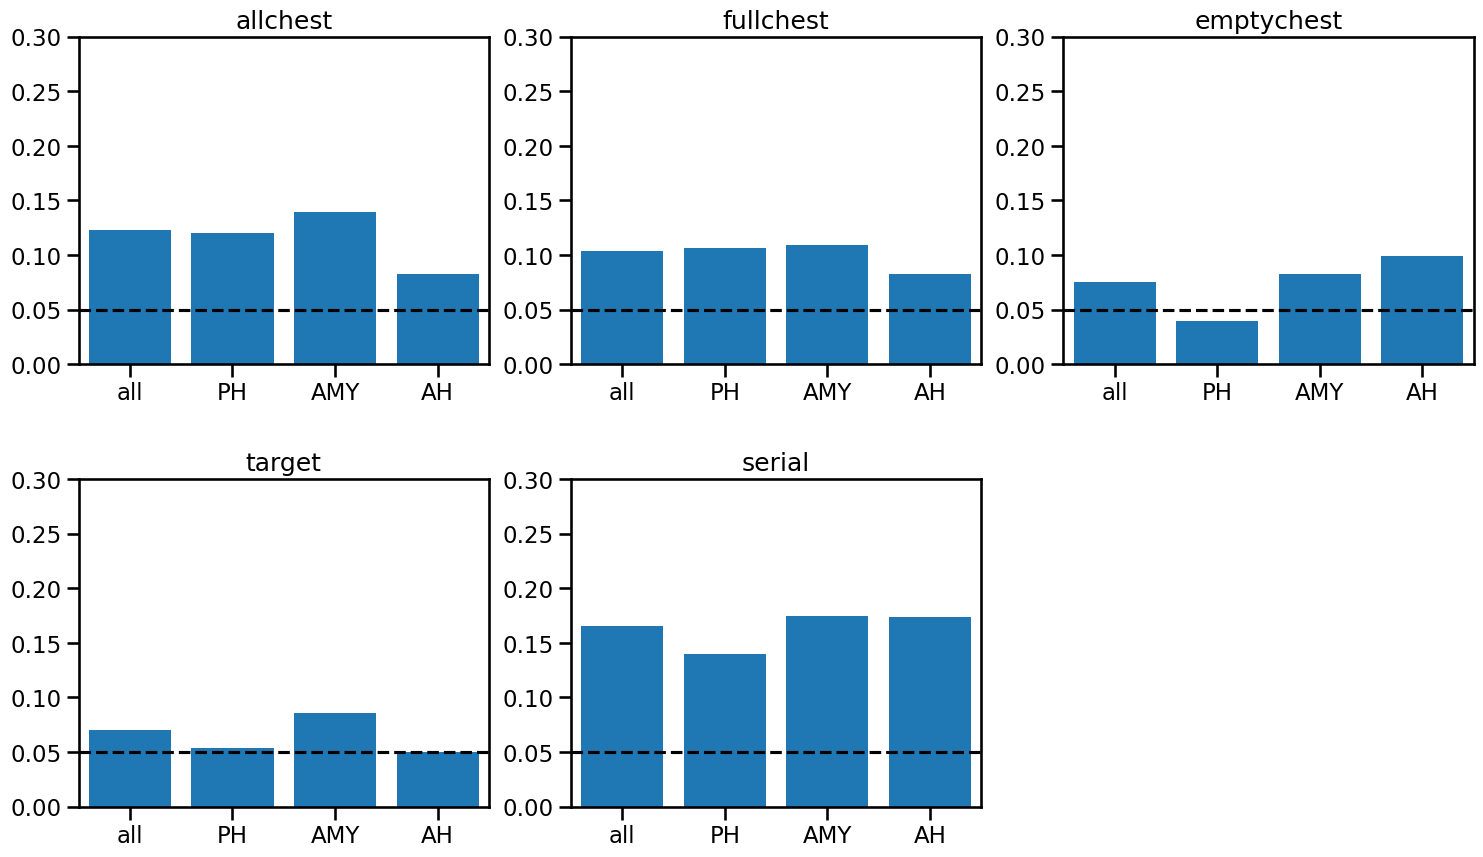

In [136]:
axes = make_axes(len(analyses), 3, hspace=0.35, figsize=(18, 10))
for analysis, ax in zip(analyses, axes):

    out = {}
    out['all'] = results[analysis] / n_units

    for value in places[place]:
        temp = all_results[all_results[place] == value]
        out[value] = sum(temp['is_' + analysis]) / len(temp)

    plot_bar(out.values(), out.keys(), title=analysis, ylim=[0, 0.30], ax=ax)
    add_hlines(0.05, linestyle='--', color='black', ax=ax)

## Within Task Overlap

Compute the overlap of labels within TH task

In [137]:
# Compute overlap between labels within TH task
over = np.zeros([len(analysis_columns), len(analysis_columns)])
for i1, acol1 in enumerate(analysis_columns):
    a1res = set(all_results[all_results[acol1]].wvID.values)
    
    for i2, acol2 in enumerate(analysis_columns):
        a2res = set(all_results[all_results[acol2]].wvID.values)
        
        over[i1, i2] = len(a1res.intersection(a2res)) / len(a1res)

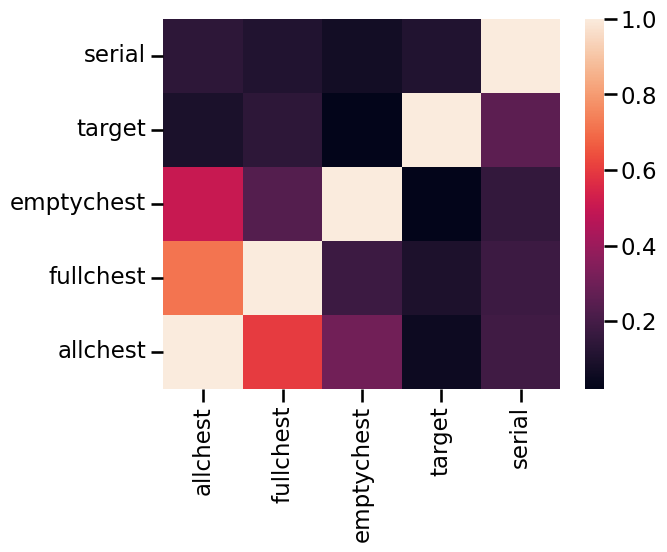

In [138]:
# Plot the overlap between TH labels
ax = sns.heatmap(over, xticklabels=analyses, yticklabels=analyses)
ax.invert_yaxis()

## Distributions

In [139]:
# Plot settings
bins = 35

### Chest Measures

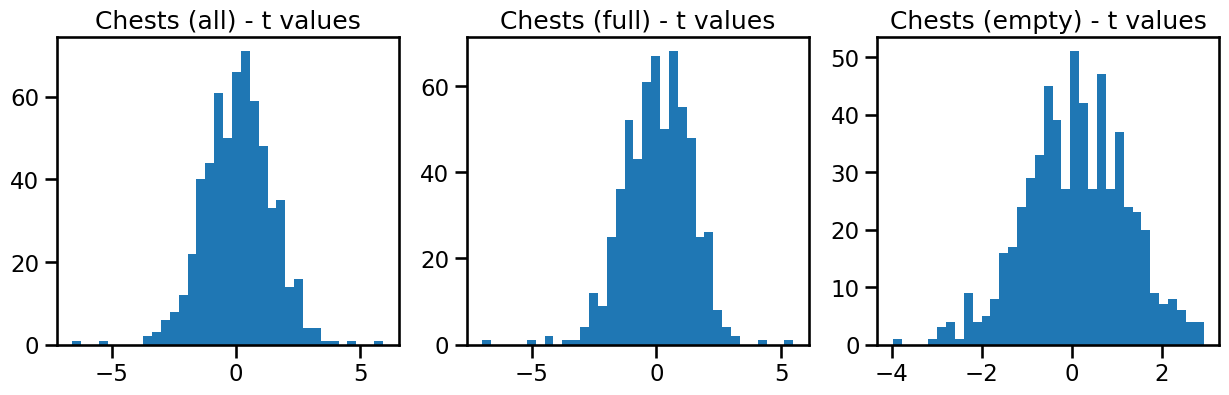

In [140]:
# Plot t-values of the chest measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.fr_t_val_all.values, title='Chests (all) - t values', bins=bins, ax=axes[0])
plot_hist(all_results.fr_t_val_full.values, title='Chests (full) - t values', bins=bins, ax=axes[1])
plot_hist(all_results.fr_t_val_empt.values, title='Chests (empty) - t values', bins=bins, ax=axes[2])

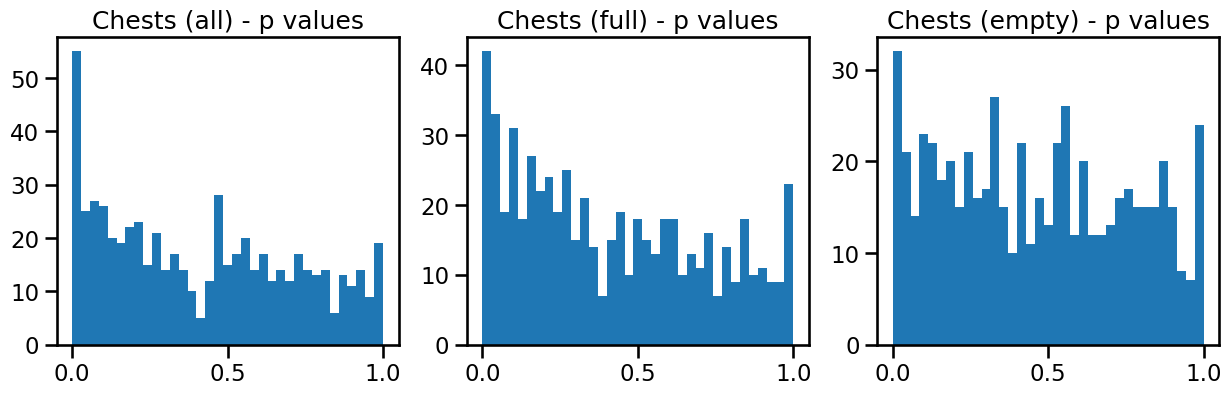

In [141]:
# Plot p-values of the chest measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.fr_p_val_all.values, title='Chests (all) - p values', bins=bins, ax=axes[0])
plot_hist(all_results.fr_p_val_full.values, title='Chests (full) - p values', bins=bins, ax=axes[1])
plot_hist(all_results.fr_p_val_empt.values, title='Chests (empty) - p values', bins=bins, ax=axes[2])

### Position & Sequence Measures

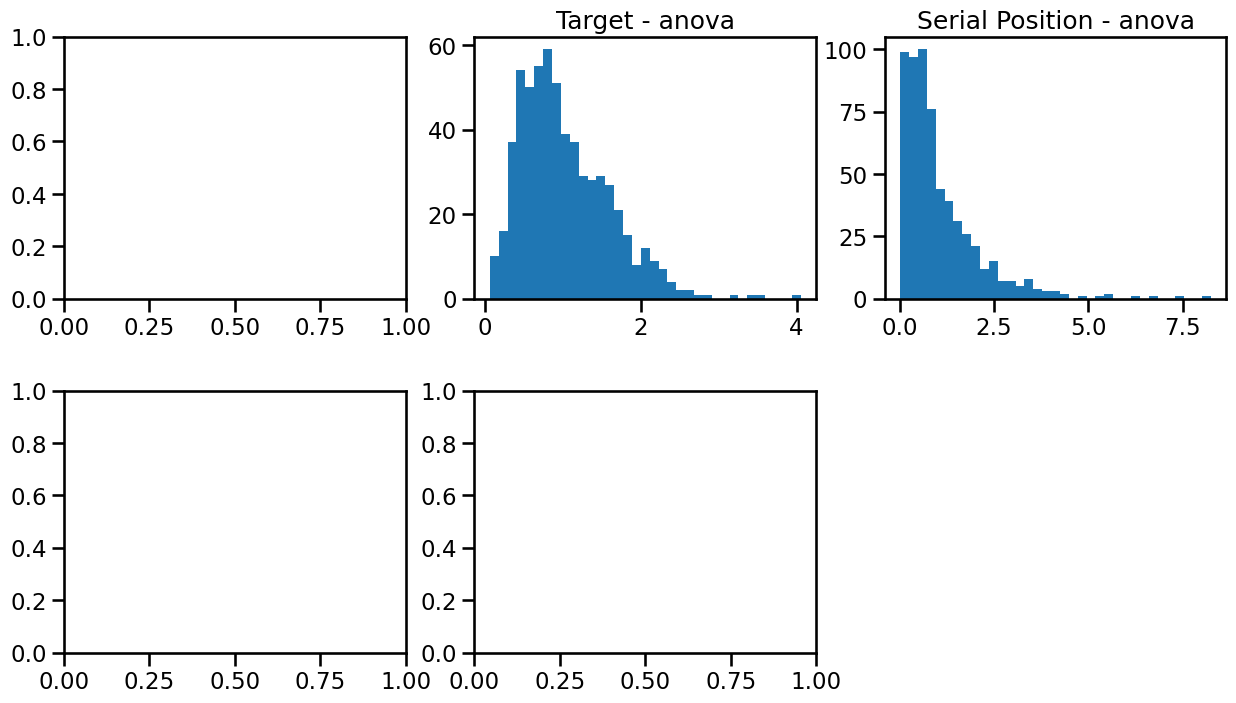

In [142]:
# Plot measure values of the position & sequence measures
axes = make_axes(6, 3, figsize=(15, 8), hspace=0.35)
#plot_hist(all_results.place_anova.values, title='Place - anova', bins=bins, ax=axes[0])
plot_hist(all_results.target_anova.values, title='Target - anova', bins=bins, ax=axes[1])
plot_hist(all_results.serial_anova.values, title='Serial Position - anova', bins=bins, ax=axes[2])
#plot_hist(all_results.place_info.values, title='Place - info', bins=bins, ax=axes[3])
#plot_hist(all_results.target_info.values, title='Target - info', bins=bins, ax=axes[4])
axes[5].set_axis_off()

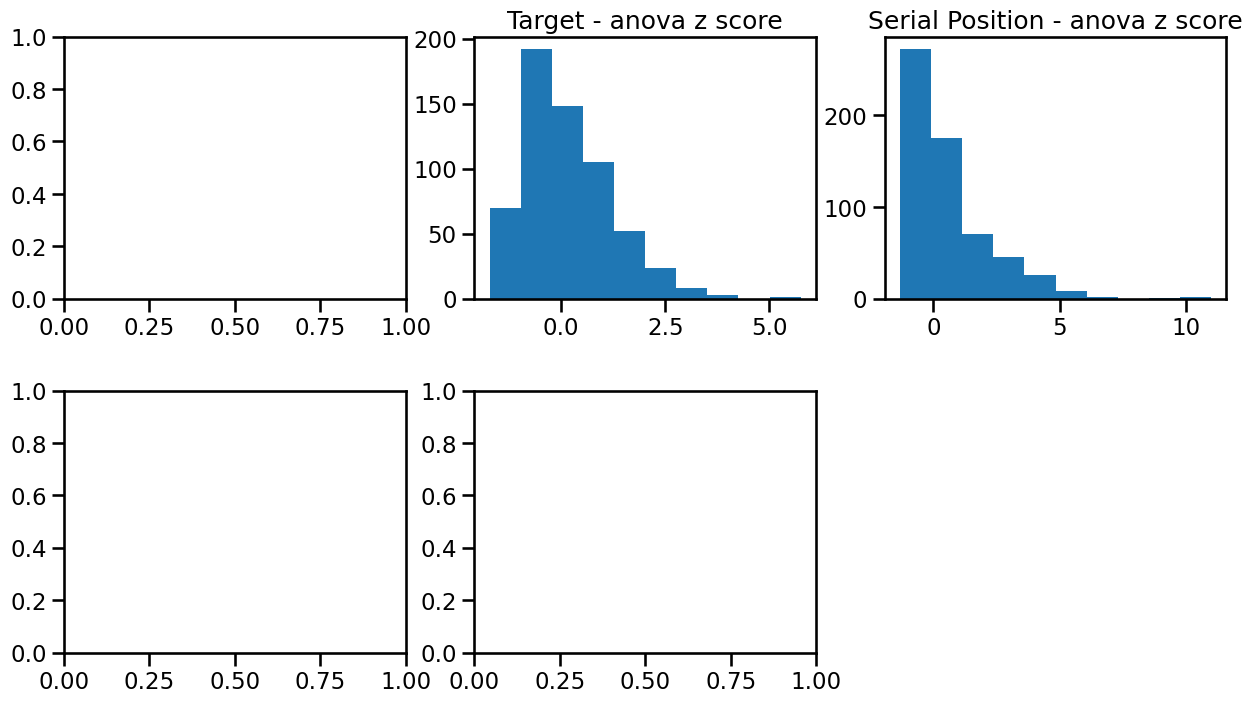

In [143]:
# Plot surrogate z-scores of the position & sequence measures
axes = make_axes(6, 3, figsize=(15, 8), hspace=0.35)
#plot_hist(all_results.place_anova_surr_z_score.values, title='Place - anova z score', ax=axes[0])
plot_hist(all_results.target_anova_surr_z_score.values, title='Target - anova z score', ax=axes[1])
plot_hist(all_results.serial_anova_surr_z_score.values, title='Serial Position - anova z score', ax=axes[2])
#plot_hist(all_results.place_info_surr_z_score.values, title='Place - info z score', ax=axes[3])
#plot_hist(all_results.target_info_surr_z_score.values, title='Target - info z score', ax=axes[4])
axes[5].set_axis_off()

In [144]:
#bins=50

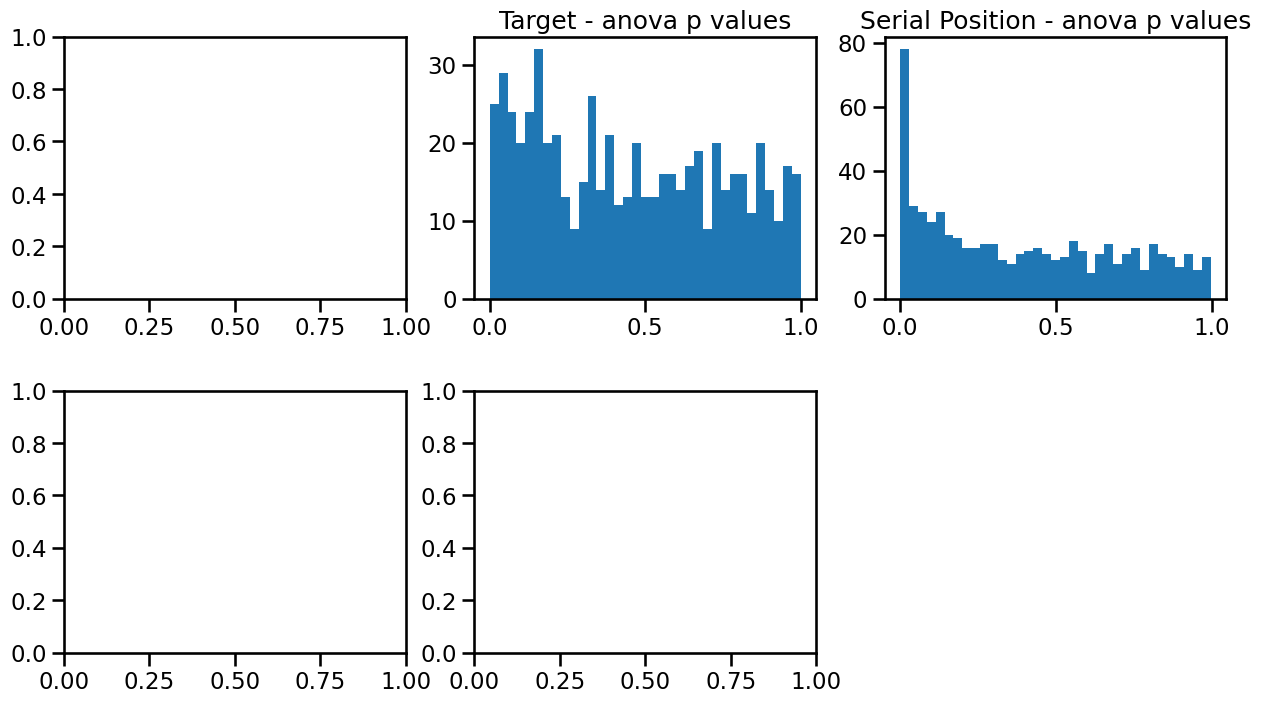

In [145]:
# Plot p values of the position & sequence measures
axes = make_axes(6, 3, figsize=(15, 8), hspace=0.35)
#plot_hist(all_results.place_anova_surr_p_val.values, title='Place - anova p values', bins=bins, ax=axes[0])
plot_hist(all_results.target_anova_surr_p_val.values, title='Target - anova p values', bins=bins, ax=axes[1])
plot_hist(all_results.serial_anova_surr_p_val.values, title='Serial Position - anova p values', bins=bins, ax=axes[2])
#plot_hist(all_results.place_info_surr_p_val.values, title='Place - info p values', bins=bins, ax=axes[3])
#plot_hist(all_results.target_info_surr_p_val.values, title='Target - info p values', bins=bins, ax=axes[4])
axes[5].set_axis_off()

## Task Overlap Analysis

In [146]:
# Define base project path
project_path = '/data12/jacobs_lab/WVTH/'

In [147]:
# Create paths object
paths = Paths(project_path)

### Identity Neuron

Identity neuron fields:
- ID_neuron: identity neuron
- MI_neuron: multiple identity neuron
- SI_neuron: single identity neuron

In [148]:
# Define the file path for the relevant nback results file
if experiment == 'THF':
    id_file_name = 'ID neuron CelebA_NavSelect MeanResponse 2SD.mat'
if experiment == 'THO':
    id_file_name = 'ID neuron ImageNet_NavSelect MeanResponse 2SD.mat'

In [149]:
# Load nback results data
nback_data = load_matfile(id_file_name, folder=paths.info / 'nback', squeeze_me=True)

In [150]:
# Check the available keys in the loaded nback data
keys = [key for key in nback_data.keys() if key[0] != '_']
keys

['CodeID', 'CodeIDNum', 'ID_neuron', 'MI_neuron', 'SI_neuron', 'selMethod']

### Baseline firing

In [151]:
# Define the file path for the relevant nback results file
if experiment == 'THF':
    file_name = 'SortedFRCelebA_Nav.mat'
if experiment == 'THO':
    file_name = 'SortedFRImageNet_Nav.mat'

In [152]:
# Load the data file
fr_data = load_matfile(file_name, folder=paths.info / 'nback', squeeze_me=True)

In [153]:
# Check the available keys in the metadata file
print([el for el in fr_data.keys() if el[0] != '_'])

['FR', 'FR_sort', 'areaCell', 'beh', 'binStep', 'binW', 'pAnova', 'pBase', 'periodsAll', 'sessions', 'timestampsOfCellAll', 'vAnova', 'vBase', 'vCell', 'vCh', 'vClusterID', 'vImg', 'vKeep', 'vReject', 'vWire']


In [154]:
# Add the baseline response firing analysis to collection of analyses
nback_data['vBase'] = fr_data['vBase']

#### Overlap Within nBack

In [155]:
# Define list of nback analyses
nback_analyses = ['ID_neuron', 'MI_neuron', 'SI_neuron', 'vBase']

In [156]:
# Compute overlap between labels within nBack task
over = np.zeros([len(nback_analyses), len(nback_analyses)])
for i1, acol1 in enumerate(nback_analyses):
    a1res = set(nback_data[acol1])
    
    for i2, acol2 in enumerate(nback_analyses):
        a2res = set(nback_data[acol2])
        
        over[i1, i2] = len(a1res.intersection(a2res)) / len(a1res)

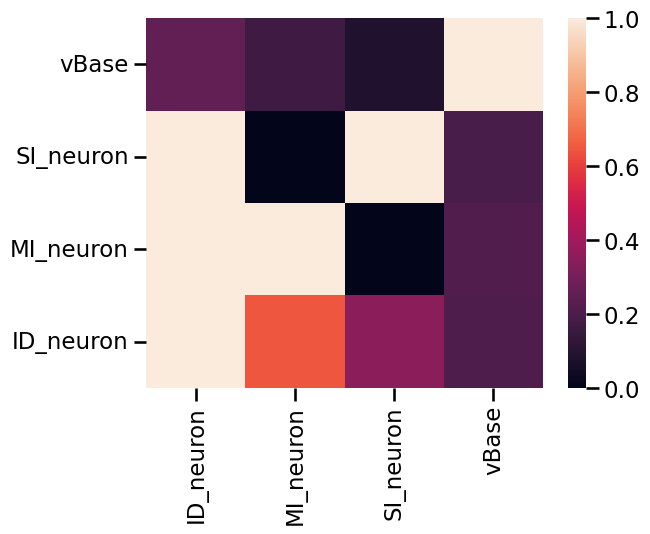

In [157]:
# Plot the overlap between nBack labels
ax = sns.heatmap(over, xticklabels=nback_analyses, yticklabels=nback_analyses)
ax.invert_yaxis()

# Compute Between Task Overlap

In [158]:
# Set which nBack analysis to compare to
nb_analysis = 'base'  # 'base', 'ID'

In [159]:
if nb_analysis == 'ID':
    nb_data = nback_data['ID_neuron']
    #nb_data = nback_data['SI_neuron']
if nb_analysis == 'base':
    nb_data = nback_data['vBase']

In [160]:
print(experiment, ' - ', nb_analysis, '\n')
print('\t {} \t {} \t {} \t {} \t\t {} \t\t{}'.format('#NB', '#TH', '#Over', '%Over', 'pval', 'exp'))
for analysis in analyses:

    th_data = all_results[all_results['is_' + analysis]].wvID.values
    n_th = len(th_data)

    n_nb = len(nb_data)
    
    inter = len(set(th_data).intersection(set(nb_data)))
    
    arr = np.array([[inter, n_th-inter],
                    [n_nb-inter, n_units-n_th-n_nb+inter]])
    tstat, pval, dof, exp = chi2_contingency(arr, False)

    print('{} \t {} \t {} \t {} \t {:5.2f}% \t {:5.4f} \t {:2d}'.format(\
        analysis, n_nb, n_th, inter, (inter / n_nb) * 100, pval, round(exp[0][0])))

THO  -  base 

	 #NB 	 #TH 	 #Over 	 %Over 		 pval 		exp
allchest 	 72 	 75 	 13 	 18.06% 	 0.1145 	  9
fullchest 	 72 	 63 	 15 	 20.83% 	 0.0019 	  7
emptychest 	 72 	 46 	 3 	  4.17% 	 0.2468 	  5
target 	 72 	 43 	 6 	  8.33% 	 0.6535 	  5
serial 	 72 	 101 	 20 	 27.78% 	 0.0065 	 12


## Combine Between Tasks

In [161]:
# Check that all the IDs line up
for nb_analysis in ['ID_neuron', 'vBase']:
    for wvid in nback_data[nb_analysis]:
        if wvid not in all_results.wvID.values:
            assert wvid in all_results.wvID.values

In [162]:
# Add columns to overall dataframe for nback task labels
all_results['is_ID_cell'] = False
all_results['is_baseline_cell'] = False

In [163]:
# Add in results from nback analyses listing which cells are nback task active cells
for wvid in all_results.wvID.values:
    if wvid in nback_data['ID_neuron']:
        all_results.loc[all_results[all_results.wvID == wvid].index[0], 'is_ID_cell'] = True
    if wvid in nback_data['vBase']:
        all_results.loc[all_results[all_results.wvID == wvid].index[0], 'is_baseline_cell'] = True

In [164]:
# Check that the alignment worked
assert set(nback_data['vBase']) == set(all_results[all_results.is_baseline_cell].wvID.values)
assert set(nback_data['ID_neuron']) == set(all_results[all_results.is_ID_cell].wvID.values)

#### Check the distribution of cells in nBack

In [165]:
# Define nback label columns to add
nback_analysis_columns = ['is_ID_cell', 'is_baseline_cell']

In [166]:
# Check the number of detected cells per session
pd.pivot_table(all_results, nback_analysis_columns, index=['subject_id', 'session_id'], aggfunc=np.sum)

is_ID_cell  is_baseline_cell
subject_id session_id                                       
wv001      THO_wv001_session_0           5                14
           THO_wv001_session_2          10                10
wv002      THO_wv002_session_0           1                 0
           THO_wv002_session_1           4                 3
           THO_wv002_session_2           2                 4
wv003      THO_wv003_session_0           5                 2
           THO_wv003_session_1           6                 6
wv004      THO_wv004_session_0          24                13
           THO_wv004_session_1          15                 8
           THO_wv004_session_2          10                 3
           THO_wv004_session_3           4                 8
wv005      THO_wv005_session_0           2                 1

In [167]:
# # Example: make a new column for overlap cells
# all_results['sp_base_overlap'] = all_results['is_sp_cell'] & all_results['is_baseline_cell']

In [168]:
# # Save out the combined results file
# all_results.to_csv(experiment + '_combined_all_results.csv')

## Overlap Stats

In [169]:
# Define the file path for the relevant nback results file
if experiment == 'THF':
    stats_filename = 'vID_vBase_Selection_CelebA_Nav.csv'
if experiment == 'THO':
    stats_filename = 'vID_vBase_Selection_ImageNet_Nav.csv'

In [170]:
# Load n-back stats
nback_stats = pd.read_csv(paths.info / 'nback' / stats_filename)

In [171]:
# Rename the CellIndex column -> WvID
new_names = {'CellIndex' : 'wvID', 'Fvalue-anova' : 'id_fvalue', 'TValue-baseline' : 'baseline_tvalue', 
             'IDNeuron' : 'is_id', 'vBaseline' : 'is_baseline'}
nback_stats.rename(columns=new_names, inplace=True)

In [172]:
# Sub-select only stats columns
nback_stats = nback_stats[['wvID', 'id_fvalue', 'baseline_tvalue', 'is_id', 'is_baseline']]

In [173]:
# Create merged df
all_results = all_results.merge(nback_stats)

In [174]:
# Create absolute value'd version of t-distributions
all_results['baseline_tvalue_abs'] = np.abs(all_results['baseline_tvalue'])
all_results['fr_t_val_full_abs'] = np.abs(all_results['fr_t_val_full'])

## FUNCS

In [175]:
MAP = {
    # 1-back Task
    'nback_stimulus' : {'stat' : 'baseline_tvalue_abs',
                        'label' : '1B Stimulus t-value',
                        'sig' : 'is_baseline'},
    
    'nback_id' : {'stat' : 'id_fvalue',
                  'label' : '1B Identity F-value',
                  'sig' : 'is_id'},
    
    # TH task
    'th_stimulus' : {'stat' : 'fr_t_val_full_abs',
                    'label' : 'TH Stimulus t-value',
                    'sig' : 'is_fullchest'},
    
    'th_serial' : {'stat' : 'serial_anova',
                   'label' : 'TH Serial F-value',
                   'sig' : 'is_serial'},
    
    'th_target' : {'stat' : 'target_anova',
                   'label' : 'TH Target F-value',
                   'sig' : 'is_target'},
}

In [176]:
from scipy.stats import spearmanr

def corr_stats(df, nb, th):
    """Calculate correlations between statistic measures."""
    
    sig = df[MAP[nb]['sig']].astype(int) + df[MAP[th]['sig']] * 2
    keys = {0 : 'null', 1 : 'NB', 2 : 'TH', 3 : 'both'}
    
    results = {}
    
    results['all'] = spearmanr(df[MAP[nb]['stat']].values,
                               df[MAP[th]['stat']].values, 
                               nan_policy='omit')
    
    for value in set(sig):
        results[keys[value]] = spearmanr(df[MAP[nb]['stat']].values[sig == value],
                                         df[MAP[th]['stat']].values[sig == value],
                                         nan_policy='omit')

    return results    

In [177]:
def print_corrs(stats, label=None):
    """Print out stats correlatins."""
    if label:
        print(label)
    for key, val in stats.items():
        print('\t {} \t- r = {:+1.2f} \t p = {:1.2f}'.format(key, val.correlation, val.pvalue))

In [200]:
import matplotlib.cm as cm

from spiketools.plts.data import plot_dots
from spiketools.plts.utils import check_ax

def plot_stats_dots(df, nb, th, ax=None, title=None):
    """Plot scatter plots across the statistics for different measures."""

    labels = ['null', '1B', 'TH', 'Both']
    colors = cm.magma_r(np.linspace(0.05, 1, 4))
    #colors = cm.cubehelix_r(np.linspace(0.15, 1, 4))
    
    sig = df[MAP[nb]['sig']].astype(int) + df[MAP[th]['sig']] * 2
    
    ax = check_ax(ax, figsize=(5, 4))
    for value, label, color in zip(set(sig), labels, colors):
        plot_dots(df[MAP[nb]['stat']].values[sig == value],
                  df[MAP[th]['stat']].values[sig == value],
                  xlabel=MAP[nb]['label'], ylabel=MAP[th]['label'],
                  title=title, label=label, color=color, alpha=0.8,
                  ax=ax)
    ax.legend(prop={'size': 10}, loc=7)
    
    stats = corr_stats(df, nb, th)
    ax.text(0.85, 0.05, 'r={:1.3f}'.format(stats['all'].correlation),
            horizontalalignment='center', verticalalignment='center',
            fontsize=12, transform=ax.transAxes)

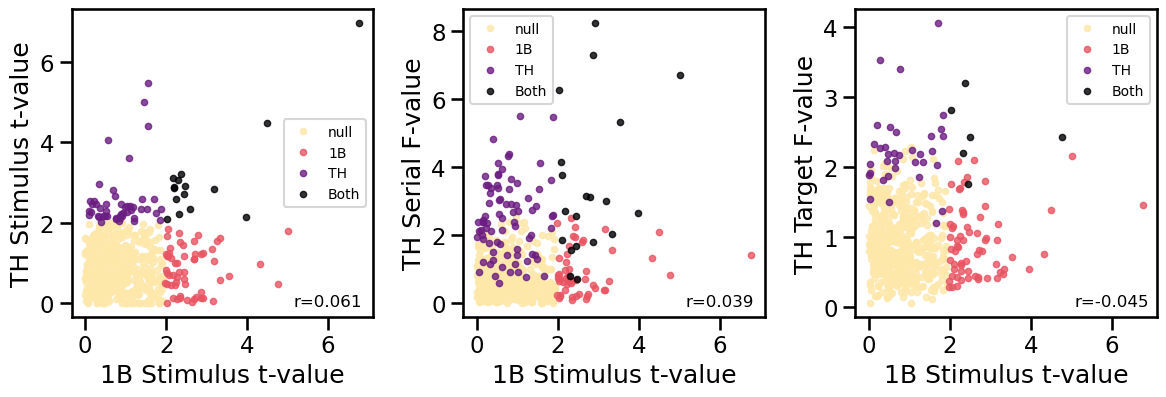

In [179]:
axes = make_axes(3, 3, wspace=0.3, figsize=(14, 4))
plot_stats_dots(all_results, 'nback_stimulus', 'th_stimulus', ax=axes[0])
plot_stats_dots(all_results, 'nback_stimulus', 'th_serial', ax=axes[1])
plot_stats_dots(all_results, 'nback_stimulus', 'th_target', ax=axes[2])
save_figure(experiment + '_stim_stats.pdf', bbox_inches='tight')

In [180]:
print_corrs(corr_stats(all_results, 'nback_stimulus', 'th_stimulus'), 'Stimulus / Stimulus')
print_corrs(corr_stats(all_results, 'nback_stimulus', 'th_serial'), 'Stimulus / Serial')
print_corrs(corr_stats(all_results, 'nback_stimulus', 'th_target'), 'Stimulus / Serial')

Stimulus / Stimulus
	 all 	- r = +0.06 	 p = 0.14
	 null 	- r = +0.01 	 p = 0.87
	 NB 	- r = +0.01 	 p = 0.92
	 TH 	- r = +0.10 	 p = 0.49
	 both 	- r = +0.25 	 p = 0.38
Stimulus / Serial
	 all 	- r = +0.04 	 p = 0.33
	 null 	- r = -0.05 	 p = 0.30
	 NB 	- r = +0.09 	 p = 0.52
	 TH 	- r = +0.06 	 p = 0.60
	 both 	- r = +0.21 	 p = 0.38
Stimulus / Serial
	 all 	- r = -0.04 	 p = 0.27
	 null 	- r = -0.08 	 p = 0.07
	 NB 	- r = +0.06 	 p = 0.63
	 TH 	- r = +0.16 	 p = 0.35
	 both 	- r = -0.26 	 p = 0.62


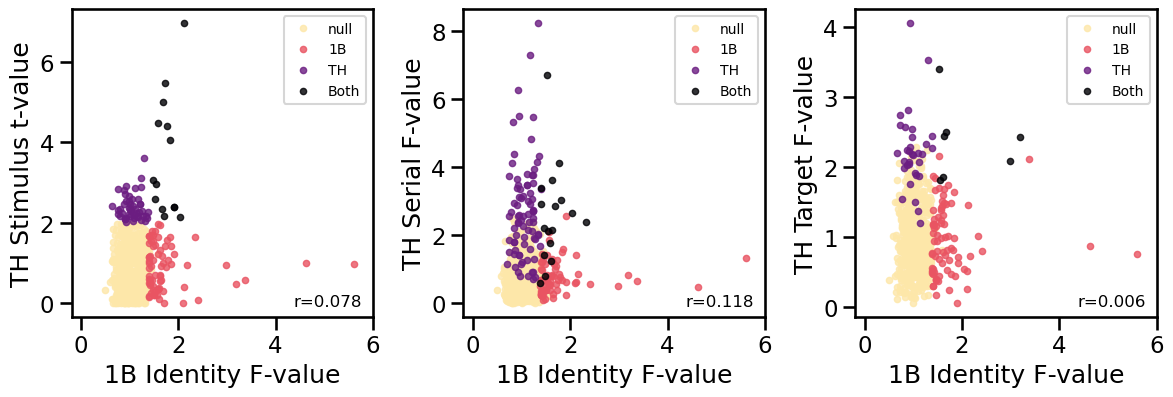

In [181]:
axes = make_axes(3, 3, wspace=0.3, figsize=(14, 4))
plot_stats_dots(all_results, 'nback_id', 'th_stimulus', ax=axes[0])
plot_stats_dots(all_results, 'nback_id', 'th_serial', ax=axes[1])
plot_stats_dots(all_results, 'nback_id', 'th_target', ax=axes[2])
if experiment == 'THO':
    for ax in axes: ax.set_xlim([-0.2, 6])
save_figure(experiment + '_id_stats.pdf', bbox_inches='tight')

In [182]:
print_corrs(corr_stats(all_results, 'nback_id', 'th_stimulus'), 'Stimulus / Stimulus')
print_corrs(corr_stats(all_results, 'nback_id', 'th_serial'), 'Stimulus / Serial')
print_corrs(corr_stats(all_results, 'nback_id', 'th_target'), 'Stimulus / Serial')

Stimulus / Stimulus
	 all 	- r = +0.08 	 p = 0.06
	 null 	- r = +0.02 	 p = 0.70
	 NB 	- r = -0.04 	 p = 0.76
	 TH 	- r = -0.07 	 p = 0.64
	 both 	- r = +0.03 	 p = 0.92
Stimulus / Serial
	 all 	- r = +0.12 	 p = 0.00
	 null 	- r = +0.07 	 p = 0.13
	 NB 	- r = +0.31 	 p = 0.01
	 TH 	- r = +0.05 	 p = 0.62
	 both 	- r = +0.32 	 p = 0.21
Stimulus / Serial
	 all 	- r = +0.01 	 p = 0.88
	 null 	- r = +0.00 	 p = 0.97
	 NB 	- r = +0.01 	 p = 0.90
	 TH 	- r = -0.12 	 p = 0.51
	 both 	- r = +0.14 	 p = 0.74


## XX

In [194]:
#raise ValueError

In [195]:
#all_results_tho = all_results
#all_results_thf = all_results

In [210]:
SAVE_FIG = False

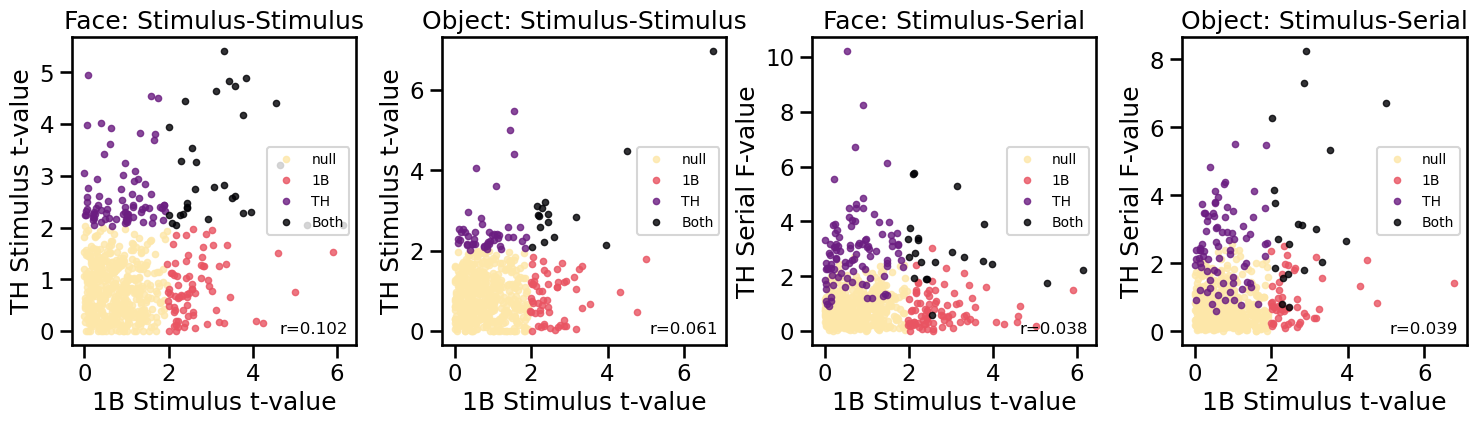

In [211]:
axes = make_axes(4, 4, wspace=0.3, figsize=(18, 4))
plot_stats_dots(all_results_thf, 'nback_stimulus', 'th_stimulus', 
                title='Face: Stimulus-Stimulus', ax=axes[0])
plot_stats_dots(all_results_tho, 'nback_stimulus', 'th_stimulus',
                title='Object: Stimulus-Stimulus', ax=axes[1])
plot_stats_dots(all_results_thf, 'nback_stimulus', 'th_serial',
                title='Face: Stimulus-Serial', ax=axes[2])
plot_stats_dots(all_results_tho, 'nback_stimulus', 'th_serial',
                title='Object: Stimulus-Serial', ax=axes[3])
if SAVE_FIG:
    save_figure('group_stats.pdf', bbox_inches='tight')